#Exploring Patterns of Population Structure and Environmental Associations to Aridity Across the Range of Loblolly Pine

##Introduction

In this set of analyses, we will be making use of data from the Eckert et al. 2010 paper to explore patterns of phenotypic and environmental associations among populations of loblolly pine.


###Abstract

Natural populations of forest trees exhibit striking phenotypic adaptations to diverse environmental
gradients, thereby making them appealing subjects for the study of genes underlying ecologically relevant phenotypes. Here, we use a genome-wide data set of single nucleotide polymorphisms genotyped across 3059 functional genes to study patterns of population structure and identify loci associated with aridity across the natural range of loblolly pine (Pinus taeda L.). Overall patterns of population structure, as inferred using principal components and Bayesian cluster analyses, were consistent with three genetic clusters likely resulting from expansions out of Pleistocene refugia located in Mexico and Florida. A novel application of association analysis, which removes the confounding effects of shared ancestry on correlations between genetic and environmental variation, identified five loci correlated with aridity. These loci were primarily involved with abiotic stress response to temperature and drought. A unique set of 24 loci was identified as FST outliers on the basis of the genetic clusters identified previously and after accounting for expansions out of Pleistocene refugia. These loci were involved with a diversity of physiological processes. Identification of nonoverlapping sets of loci highlights the fundamental differences implicit in the use of either method and suggests a pluralistic, yet complementary, approach to the identification of genes underlying ecologically relevant phenotypes.


##Overview of tasks

In general, what you will be doing is working your way from loading and saving data related to this study, to corrections for population structure, to looking for associations between genotypes and phenotypes, genotypes and the environment (`Bayenv2`), and genotypes+phenotypes+environment (`SQUAT`)

## This notebook

This notebook will take you through executing Principal Components Analysis on the data, checking for outliers (and fixing them) and determining how many PCA axes to use for downstream correction of population structure.

You will:

1. Interface between Python and R to execute some commands
1. Get some experience with plotting in matplotlib
1. Create and save PCA axes
1. Learn about applying commands to `DataFrames`, similar to `R`'s (`apply`, `sapply`, `mapply`, etc)

As with the previous notebook, execute the cell with the imports and continue

In [55]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

%load_ext autoreload
%autoreload 2

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


####Set up some functions again

In [56]:
def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False


def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        for allele in [x.strip() for x in gt.split("/")]:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het


def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)


def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret


def plot_hist(df, index):
    d = df.ix[index,:]
    plt.hist(d, bins=20)
    plt.title("%s %.2f $\pm$ %.3f [%.2f, %.2f]" % (index, 
                                                   np.mean(d), 
                                                   np.std(d),
                                                  np.min(d),
                                                  np.max(d)))
    

def convert_to_z12(locus):
    freq = af[locus.name]
    trans = {"%s/%s" % (freq["A"],freq["A"]): 0,
            "%s/%s" % (freq["a"],freq["a"]): 2,
            "%s/%s" % (freq["A"],freq["a"]): 1,
            "%s/%s" % (freq["a"],freq["A"]): 1,
            "?/?":-1}
    return locus.apply(lambda x: trans[x])


def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)


def center_and_standardize(snp):
    maf = af.ix["q",snp.name]
    u = np.mean([x for x in snp if x != -1])
    var = np.sqrt(maf*(1-maf))
    return snp.apply(center_and_standardize_value, args=(u, var))

In [57]:
hdf = HDFStoreHelper("data.hd5")

####The cell below sets up the interface between Pythong and R.  You'll see.  It's slick.

In [58]:
r = ro.r
prcomp = r('prcomp')
summary = r('summary')

####The following cells will perform:

1. retrieval of the normalized genotypes for PCA
1. Sending that data to R, running `prcomp` and saving the results back in Python
1. Extracting individual component data from the `prcomp_res` object.
1. Plotting PC1 vs PC2

In [59]:
pca_std = hdf.get('pca_std')
prcomp_res = prcomp(pca_std, scale=False, center=False)

In [60]:
print(summary(prcomp_res))

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     6.07193 4.20751 3.79014 3.20076 3.08532 3.04595 2.96424
Proportion of Variance 0.01789 0.00859 0.00697 0.00497 0.00462 0.00450 0.00426
Cumulative Proportion  0.01789 0.02649 0.03346 0.03843 0.04305 0.04755 0.05182
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.93988 2.89841 2.88317 2.83414 2.82524 2.80280 2.79039
Proportion of Variance 0.00419 0.00408 0.00403 0.00390 0.00387 0.00381 0.00378
Cumulative Proportion  0.05601 0.06009 0.06412 0.06802 0.07190 0.07571 0.07949
                          PC15    PC16    PC17    PC18    PC19    PC20   PC21
Standard deviation     2.75606 2.74385 2.73991 2.72647 2.71721 2.70782 2.6857
Proportion of Variance 0.00369 0.00365 0.00364 0.00361 0.00358 0.00356 0.0035
Cumulative Proportion  0.08317 0.08683 0.09047 0.09408 0.09766 0.10122 0.1047
                          PC22

In [61]:
x = com.convert_robj(prcomp_res.rx2("x"))
x.index = pca_std.index
x.ix[0:5,0:10]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-4.227659,-0.930500,1.853226,-2.682931,0.923642,-0.432286,2.962403,-1.233186,2.818495,-0.604278
1,0.888892,-0.179881,-8.694134,-2.872412,-3.320970,1.533524,-1.861266,-1.118133,-3.388559,1.083895
2,-3.319852,2.300243,1.670677,-9.666361,-9.595642,4.668615,-20.648915,2.828419,13.892349,6.112814
3,-5.508931,-1.505746,5.299569,5.727700,-4.449550,-0.807838,2.172512,5.269906,5.609469,2.110526
4,-6.334801,-0.261818,6.637892,5.268738,0.579049,-0.522321,0.370901,-3.753941,-0.828416,3.331711
5,-3.629128,-0.334265,2.039921,-3.229526,-1.352967,5.201557,-0.460188,2.400639,-3.360119,0.391390


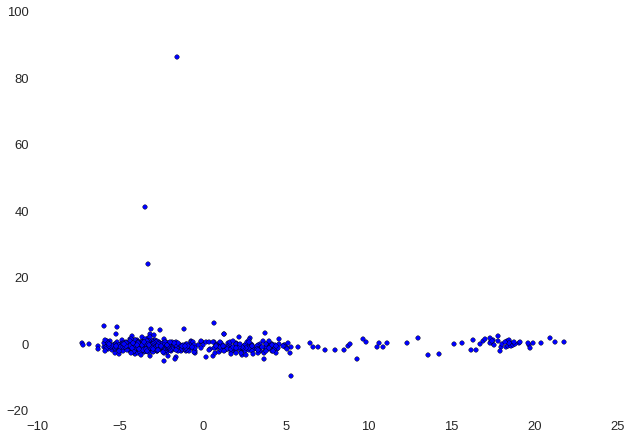

In [62]:
plt.scatter(x.PC1, x.PC2)
plt.show()

####Notice anything about this plot?

* Does it look like you would expect a PCA plot to look like?
* In the paper, they do end up making some corrections for outliers.

####Just for fun, let's see how many axes might describe the population structure.

In [63]:
%%R
source("tw_calc.R")
test=read.table("twtable", header=F)

In [64]:
TWcalc = r('TWcalc')
tw = TWcalc(com.convert_to_r_matrix(pca_std), 25)
tw_p = com.convert_robj(tw.rx2(2))
tw_e = com.convert_robj(tw.rx2(1))
tw_num = 0
for i, p in enumerate(tw_p):
    print i, p
    if p > 0.05:
        tw_num = i
        break
print "Tracy-Widom test yields %d axes of pop structure" % tw_num

0 8e-09
1 8e-09
2 8e-09
3 8e-09
4 8e-09
5 8e-09
6 8e-09
7 8e-09
8 8e-09
9 8e-09
10 8e-09
11 8e-09
12 8e-09
13 8e-09
14 2.2872e-05
15 0.000220344
16 0.000177359
17 0.00206759
18 0.006211384
19 0.01992964
20 0.328982392
Tracy-Widom test yields 20 axes of pop structure


####Hmmm, that seems like a lot.  Let's fix it with some outlier exclusion.  

Can you describe what might be happening here?  If not, maybe it's in the paper...

In [65]:
y = pd.DataFrame(x)
for col in y.columns[0:10]:
    s_cutoff = np.std(y[col])*6
    u = np.mean(y[col])
    cutoff = sorted([u+s_cutoff, u-s_cutoff], reverse=True)
    outliers = y[col][(y[col] > cutoff[0]) | (y[col] < cutoff[1])]
    print col
    print outliers
    y = y.drop(outliers.index)
y.ix[0:5,0:10]

PC1
Series([], name: PC1, dtype: float64)
PC2
348    86.725320
572    41.627337
Name: PC2, dtype: float64
PC3
Series([], name: PC3, dtype: float64)
PC4
596    23.223851
Name: PC4, dtype: float64
PC5
303   -15.047861
Name: PC5, dtype: float64
PC6
9     -32.477463
271   -25.089614
296   -25.141168
603   -22.043115
Name: PC6, dtype: float64
PC7
2     -20.648915
333   -17.148680
391   -17.088184
Name: PC7, dtype: float64
PC8
290   -30.003228
561   -25.400725
Name: PC8, dtype: float64
PC9
578    15.177391
Name: PC9, dtype: float64
PC10
606   -17.195924
Name: PC10, dtype: float64


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-4.227659,-0.930500,1.853226,-2.682931,0.923642,-0.432286,2.962403,-1.233186,2.818495,-0.604278
1,0.888892,-0.179881,-8.694134,-2.872412,-3.320970,1.533524,-1.861266,-1.118133,-3.388559,1.083895
3,-5.508931,-1.505746,5.299569,5.727700,-4.449550,-0.807838,2.172512,5.269906,5.609469,2.110526
4,-6.334801,-0.261818,6.637892,5.268738,0.579049,-0.522321,0.370901,-3.753941,-0.828416,3.331711
5,-3.629128,-0.334265,2.039921,-3.229526,-1.352967,5.201557,-0.460188,2.400639,-3.360119,0.391390


In [66]:
genotypes = hdf.get("genotypes")
gt_drop = genotypes.ix[y.index,:]
gt_drop.head()

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,A/C,?/?,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,?/?,G/G,A/A,C/C,G/G,C/C,A/G
1,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,A/G,C/C,A/A
3,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,A/G,C/C,G/G
4,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,A/C,?/?,...,A/A,T/T,C/G,C/C,G/G,A/A,C/G,A/A,C/C,A/G,A/A,A/C,G/G,A/C,G/G
5,A/G,C/C,C/G,A/A,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/G,C/C,A/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,G/G,A/C,A/G


In [67]:
af = hdf.get("af")
z12_drop = gt_drop.apply(convert_to_z12)
z12_drop.head()

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,2,1,2,2,0,1,0,0,1,0,0,0,0,1,-1,...,0,0,0,1,1,0,1,0,-1,0,0,0,0,0,1
1,0,0,2,2,0,1,0,1,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0,0,1,1,0,2
3,0,2,0,0,1,0,0,0,0,1,0,0,0,2,0,...,0,0,0,0,0,0,1,0,-1,1,0,1,1,0,0
4,0,1,0,-1,0,1,0,0,0,0,0,0,-1,1,-1,...,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0
5,1,0,1,2,0,1,0,0,0,1,0,0,0,2,0,...,0,0,1,0,1,0,1,0,-1,1,0,1,0,1,1


In [68]:
pca_drop_std = z12_drop.apply(center_and_standardize)

In [69]:
hdf.put('pca_drop_std', pca_drop_std)

updating pca_drop_std


In [70]:
prcomp_res_drop = prcomp(pca_drop_std, scale=False, center=False)

In [71]:
x_drop = com.convert_robj(prcomp_res_drop.rx2("x"))
x_drop.index = pca_drop_std.index
x_drop.ix[0:5,0:5]

,PC1,PC2,PC3,PC4,PC5
0,-4.333631,1.477887,2.473628,-2.610228,3.732781
1,0.972361,-8.577780,2.513130,8.103148,2.426614
3,-5.587363,4.702591,-5.712560,1.822264,-5.001879
4,-6.356667,6.632884,-6.070111,-0.607114,4.199792
5,-3.653699,2.052517,5.030496,2.775605,6.097295


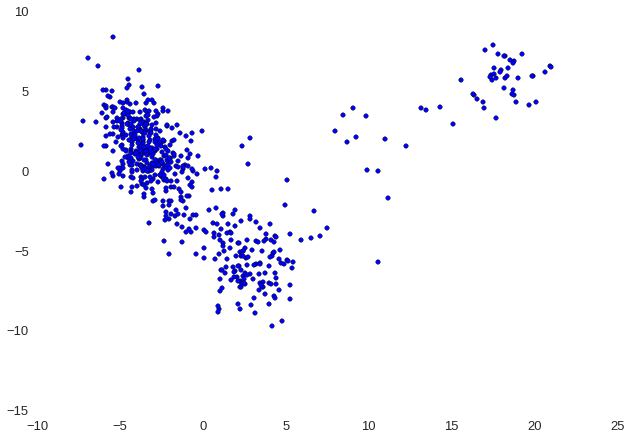

In [72]:
plt.scatter(x_drop.PC1, x_drop.PC2)
plt.show()

In [73]:
print summary(prcomp_res_drop)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     6.04309 3.80099 3.14407 2.95914 2.89047 2.85444 2.82015
Proportion of Variance 0.01799 0.00712 0.00487 0.00431 0.00412 0.00401 0.00392
Cumulative Proportion  0.01799 0.02511 0.02998 0.03430 0.03841 0.04243 0.04635
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.80660 2.79209 2.78734 2.77330 2.76292 2.74726 2.73089
Proportion of Variance 0.00388 0.00384 0.00383 0.00379 0.00376 0.00372 0.00367
Cumulative Proportion  0.05023 0.05407 0.05790 0.06169 0.06545 0.06917 0.07284
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     2.70648 2.70016 2.69946 2.69158 2.68432 2.68015 2.66814
Proportion of Variance 0.00361 0.00359 0.00359 0.00357 0.00355 0.00354 0.00351
Cumulative Proportion  0.07645 0.08004 0.08364 0.08720 0.09076 0.09429 0.09780
                         P

In [74]:
tw = TWcalc(com.convert_to_r_matrix(pca_drop_std), 25)
tw_p = com.convert_robj(tw.rx2(2))
tw_e = com.convert_robj(tw.rx2(1))
tw_num = 0
for i, p in enumerate(tw_p):
    print i, p
    if p > 0.05:
        tw_num = i
        break
print "Tracy-Widom test yields %d axes of pop structure" % tw_num

0 8e-09
1 8e-09
2 8e-09
3 8e-09
4 8e-09
5 8e-09
6 8e-09
7 5.9e-08
8 1.501e-06
9 1.501e-06
10 2.8955e-05
11 0.000177359
12 0.003013114
13 0.042180992
14 0.573774198
Tracy-Widom test yields 14 axes of pop structure


####OK, that was a lot of work you just did.  To recap:

1. We found the outliers based on some criteria (Did you figure it out/look it up?)
1. We removed those outliers from the raw base/base data
1. We normalized the data again, performed PCA, and tested with T-W.  

How many axes of pop structure are left now?  Does that seem reasonable?

####The next section deals with hierfstat.  Sam already talked a little bit about this, but...

1. We have to transform our data again to their format
1. We're going to us the 012 data that does not contain outliers.
1. We're going to stash a copy of the input data for later use with `Bayenv`.  I do this because I care about you.
1. Because hierfstat knows about populations, we need to get that data in there, too.  Run the next few cells until that's done.  You'll know it's done when you write the `hierf.txt` file.

In [75]:
hierf_trans = {0:11, 1:12, 2:22, -1:'NA'}
def apply_hierf_trans(series):
    return [hierf_trans[x] if x in hierf_trans else x for x in series]

In [76]:
hierf_df = z12_drop.apply(apply_hierf_trans)

In [77]:
hierf_df.insert(0, "countyid", None)
hierf_df.head()

,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,None,22,12,22,22,11,12,11,11,12,11,11,11,11,12,...,11,11,11,12,12,11,12,11,NA,11,11,11,11,11,12
1,None,11,11,22,22,11,12,11,12,11,22,11,11,11,12,...,11,11,11,11,11,11,11,11,22,11,11,12,12,11,22
3,None,11,22,11,11,12,11,11,11,11,12,11,11,11,22,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,None,11,12,11,NA,11,12,11,11,11,11,11,11,NA,12,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,None,12,11,12,22,11,12,11,11,11,12,11,11,11,22,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12


In [78]:
data_loc = hdf.get("data_loc")
loc_hierf = data_loc.join(hierf_df, how="inner")
loc_hierf.head()

,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,CHEROKEE,GA,34.24000,-84.47000,CHEROKEE_GA,NaN,22,12,22,22,11,12,11,11,12,...,11,11,11,12,12,11,12,11,NA,11,11,11,11,11,12
1,BARTOW,GA,34.24000,-84.84000,BARTOW_GA,NaN,11,11,22,22,11,12,11,12,11,...,11,11,11,11,11,11,11,11,22,11,11,12,12,11,22
3,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,22,11,11,12,11,11,11,11,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,12,11,NA,11,12,11,11,11,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,NEW KENT,VA,37.51160,-76.97319,NEW KENT_VA,NaN,12,11,12,22,11,12,11,11,11,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12


In [79]:
hdf.put("loc_hierf", loc_hierf)
hdf.put("bayenv_df", loc_hierf)

updating loc_hierf
updating bayenv_df


In [80]:
loc_hierf['county_state'] = loc_hierf.apply(lambda row: "%s_%s" % (row.county, row.state), axis=1)
usable_counties = set()
county_counts = loc_hierf.county_state.value_counts()
county_counts = county_counts.sort(inplace=False, ascending=False)
for c in county_counts.index:
    print c, county_counts[c]
for c in county_counts.index:
    if county_counts[c] >=5:
        usable_counties.add(c)
usable_counties = sorted(list(usable_counties))

county_id = {}
for i, county in enumerate(usable_counties):
    county_id[county] = i+1
county_id

loc_hierf['usable'] = loc_hierf.apply(lambda row: row.county_state in county_id, axis=1)

drop = loc_hierf[loc_hierf.usable==False]

loc_hierf = loc_hierf.drop(drop.index)

loc_hierf['countyid'] = loc_hierf.apply(lambda row: county_id[row.county_state], axis=1)

loc_hierf.head()

TUSCALOOSA_AL 63
BEAUFORT_NC 36
CRAVEN_NC 23
PICKENS_AL 17
GREENE_AL 17
CHOCTAW_AL 13
MARION_FL 13
ONSLOW_NC 13
BRUNSWICK_NC 11
LEVY_FL 11
NEWBERRY_SC 11
HERTFORD_NC 10
GEORGETOWN_SC 10
PRINCE GEORGE_VA 9
ANSON_NC 9
BRUNSWICK_VA 8
MECKLENBURG_VA 8
DINWIDDIE_VA 8
BERKELEY_SC 7
WAKE_NC 7
BERTIE_NC 7
SUMTER_AL 7
McCURTAIN_OK 7
WILCOX_AL 7
MARENGO_AL 6
CLARKE_AL 6
MARTIN_NC 6
JASPER_MS 6
HALIFAX_NC 6
COLUMBUS_NC 6
CHESTERFIELD_VA 5
SUSSEX_VA 5
SPOTSYLVANIA_VA 5
CLEVELAND_AR 5
HALE_AL 4
POLK_TX 4
LAMAR_AL 4
HALIFAX_VA 4
KING & QUEEN_VA 4
RICHMOND_NC 4
FLUVANNA_VA 4
SALUDA_SC 4
MOORE_NC 4
FRANKLIN_NC 3
GATES_NC 3
CALHOUN_AL 3
CUMBERLAND_VA 3
CLARKE_MS 3
CHOWAN_NC 3
WINSTON_AL 3
HOUSTON_TX 3
TYRRELL_NC 3
CALHOUN_AR 3
LUNENBURG_VA 3
GREENWOOD_SC 3
JONES_NC 3
BIBB_AL 3
JASPER_SC 3
NEW KENT_VA 3
WARREN_NC 3
DURHAM_NC 2
NORTHAMPTON_NC 2
FAYETTE_AL 2
BAMBERG_SC 2
YORK_SC 2
BARTOW_GA 2
MARSHALL_AL 2
CONECUH_AL 2
LEE_NC 2
CHATTOOGA_GA 2
PASQUOTANK_NC 2
UNION_SC 2
ROWAN_NC 2
DORCHESTER_SC 2
DALLAS_AL

,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,...,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,usable
8,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,11,11,11,...,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22,True
10,ONSLOW,NC,34.75963,-77.40977,ONSLOW_NC,26,11,22,12,11,11,12,11,11,11,...,11,11,11,12,11,12,11,12,11,11,11,12,11,11,True
11,ONSLOW,NC,34.75963,-77.40977,ONSLOW_NC,26,11,12,NA,12,11,12,11,11,11,...,11,11,12,NA,11,11,11,11,11,11,11,12,11,12,True
12,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,11,11,12,...,11,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA,True
13,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,11,11,11,...,12,11,11,11,11,11,11,12,11,11,22,11,12,11,True


In [81]:
dill.dump(county_id, open("county_id.dill","w"))

In [82]:
loc_hierf.ix[:,4:-2].to_csv("hierf.txt", sep="\t", header=True, index=False)

I've already run this for you, but just in case you wanted to do something like it in the future, the code is below.  Expect it to take a few hours, or days/weeks for huge datasets.


```
library(hierfstat)
data = read.table("hierf.txt", header=T, sep="\t")
data = data[order(data$countyid),]
levels = data.frame(data$countyid)
loci = data[,2:ncol(data)]
bs = basic.stats(data)
saveRDS(bs, "basic_stats.rds")
res = varcomp.glob(levels=levels, loci=loci, diploid=T)
saveRDS(res, "hierf.rds")
```

####Let's read that hierfstat into R, so we can get it into Python.  

No seriously, it's better.  Trust me.

In [83]:
%%R
bs = readRDS("basic_stats.rds")
res = readRDS("hierf.rds")

In [84]:
res = com.convert_robj(ro.r('res'))
bs = com.convert_robj(ro.r('bs'))
Fis = bs['Fis']
Hs = bs['Hs']
pop_freq_temp = bs['pop.freq']
pop_freq = {}
perloc = bs['perloc']
n_ind_samp = bs['n.ind.samp']
Ho = bs['Ho']
overall = bs['overall']

for df in [Fis, Hs, perloc, n_ind_samp, Ho]:
    df.index = [x[1:].replace(".","-") for x in df.index]

for locus, data in pop_freq_temp.items():
    if len(data) == 2:
        data.index = ['p','q']
    else:
        data.index = ['p']
    pop_freq[locus[1:].replace(".", "-")] = data

Ho = Ho.T
perloc = perloc.T
n_ind_samp = n_ind_samp.T
Hs = Hs.T
Fis = Fis.T

####You know have matrices for Ho, perloc, n_ind_samp, Hs, and Fis from hierfstat available as `DataFrame`s.  

Add some cells and explore them with head()

In [85]:
loc_df = res['loc']
F_df = res['F']
overall_df = res['overall']

####What data is contained in the F matrix (`F_df`)?  

In [86]:
F_df

,data.countyid,Ind
Total,0.009032,0.014992
data.countyid,0.000000,0.006014


####We can compute $F_{ST}$ for each site, as well, from the variance components in `loc_df`.

In [87]:
def compute_fst(series):
    Va = series[0]
    Vt = sum(series)
    return Va/Vt

In [88]:
loci_fst = loc_df.apply(compute_fst, axis=1).dropna()
loci_fst.index = [x[1:].replace(".", "-") for x in loci_fst.index]

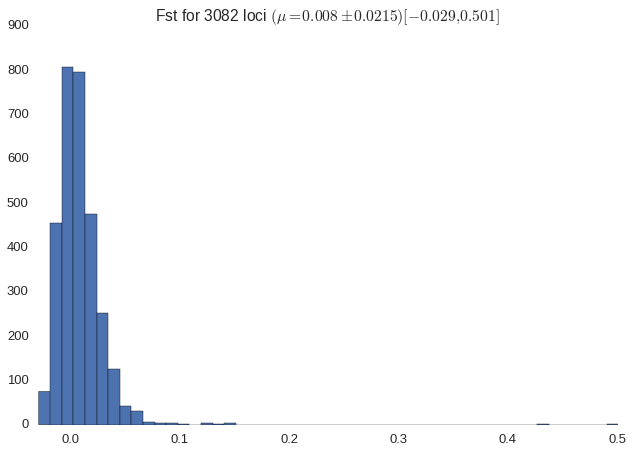

In [89]:
plt.hist(loci_fst, bins=50)
plt.xlim(-.03, .5)
plt.title("Fst for %d loci $(\mu=%.3f \pm %.4f) [%.3f, %.3f]$" % (len(loci_fst),
                                                                  np.mean(loci_fst),
                                                                  np.std(loci_fst),
                                                                  np.min(loci_fst),
                                                                  np.max(loci_fst)))
plt.show()

In [90]:
loci_fst[loci_fst>0.1]

0-10240-01-410        0.146357
0-16169-01-216        0.103805
0-16732-01-386        0.128952
0-16849-03-97         0.500960
0-2179-01-216         0.135076
0-4446-01-62          0.132486
0-7745-01-176         0.144930
L2125Contig1-04-84    0.150094
MN-2809-01-235        0.429184
MN-4783-01-396        0.120912
MN-897-01-82          0.125378
dtype: float64

####Let's now join up our phenotype data with our hierfstat data.

You'll often find that you'll have to do this, especially when working in collaboration across groups.  It's not ideal, as you'll see, because not everything matches up.  Oh well, moving on.

In [91]:
def get_phenotype(row):
    return np.max(pheno[(pheno.Longitude==row.long) & (pheno.Latitude==row.lat)])

pheno = hdf.get("pheno")
trait = loc_hierf.apply(get_phenotype, axis=1)

In [92]:
trait.head()

,Longitude,Latitude,fructose
8,-78.70453,34.33010,5.824822
10,NaN,NaN,NaN
11,NaN,NaN,NaN
12,-79.30539,33.36318,5.958635
13,-77.05205,35.55349,5.945595


####Inner, outer (left, right) joins are possible in Python, too.

In [93]:
trait_loc_hierf = trait.join(loc_hierf, how="inner")

####Let's drop populations that do not have data for your favorite trait.

Remember saving that file?

In [94]:
trait_name = dill.load(open("trait_name.dill"))
trait_complete = trait_loc_hierf.drop(trait_loc_hierf[np.isnan(trait_loc_hierf[trait_name])].index)

####Let's set up our PCA matrix to only have the axes that relate to our population structure, and save the rest of the data out for later.

In [95]:
pca_cov = x_drop.ix[:,0:14]

In [96]:
hdf.put("trait_complete", trait_complete)
hdf.put("x_drop", x_drop)
hdf.put("pca_cov", pca_cov)

updating trait_complete
updating x_drop
updating pca_cov


In [97]:
trait_complete

,Longitude,Latitude,fructose,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,...,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,usable
8,-78.70453,34.33010,5.824822,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22,True
12,-79.30539,33.36318,5.958635,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,...,11,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA,True
13,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,...,12,11,11,11,11,11,11,12,11,11,22,11,12,11,True
15,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,12,12,12,12,11,12,...,11,11,11,11,11,12,11,12,12,11,11,12,11,11,True
18,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,22,11,12,12,...,11,11,11,11,12,11,11,NA,11,11,12,11,11,11,True
20,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,11,12,12,22,11,22,...,11,12,11,12,11,12,11,11,11,12,11,12,22,11,True
21,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,11,12,11,12,11,12,...,11,22,12,22,11,11,11,12,12,11,12,11,11,11,True
24,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,11,22,11,11,11,12,...,22,11,11,11,11,12,11,11,11,11,12,12,11,11,True
25,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,12,NA,11,11,22,...,11,12,11,12,11,12,11,12,11,11,12,11,11,11,True
26,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,11,11,11,12,...,11,12,22,11,12,12,11,12,11,11,11,11,11,12,True


In [98]:
for key, df in {"Fis":Fis, 
                "Hs":Hs, 
                "perloc": perloc, 
                "n_ind_samp":n_ind_samp, 
                "Ho":Ho}.items():
    hdf.put(key, df)

updating Fis
updating perloc
updating Ho
updating n_ind_samp
updating Hs


In [99]:
hdf.put("trait_complete", trait_complete)

updating trait_complete
